In [1]:
!pip install -q efficientnet_pytorch

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd

In [3]:
from fastai import *
from fastai.utils import *
from fastai.vision import *
from fastai.callbacks import *
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
from torch.utils import model_zoo

%matplotlib inline

In [4]:
from efficientnet_pytorch import EfficientNet

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
print(os.listdir('.'))

['.ipynb_checkpoints', '__notebook_source__.ipynb']


In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [8]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [9]:
print(os.listdir('../input'))

['train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


In [10]:
hack_path = Path('../input')

In [11]:
# Load train dataframe
train_df = pd.read_csv(hack_path/'train/train.csv')
test_df = pd.read_csv(hack_path/'test_ApKoW4T.csv')
sample = pd.read_csv(hack_path/'sample_submission_ns2btKE.csv')

In [12]:
def get_data(bs, size):
    data = ImageDataBunch.from_df(df=train_df, path=hack_path/'train', folder='images',
                                  bs=bs, size=size, valid_pct=0.1, 
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms=get_transforms(max_lighting=0.4, max_zoom=1.2, 
                                                         max_warp=0.2, max_rotate=20, 
                                                         xtra_tfms=[flip_lr()]))
    test_data = ImageList.from_df(test_df, path=hack_path/'train', folder='images')
    data.add_test(test_data)
    data.normalize(imagenet_stats)
    return data

In [13]:
data = get_data(bs=48, size=224)

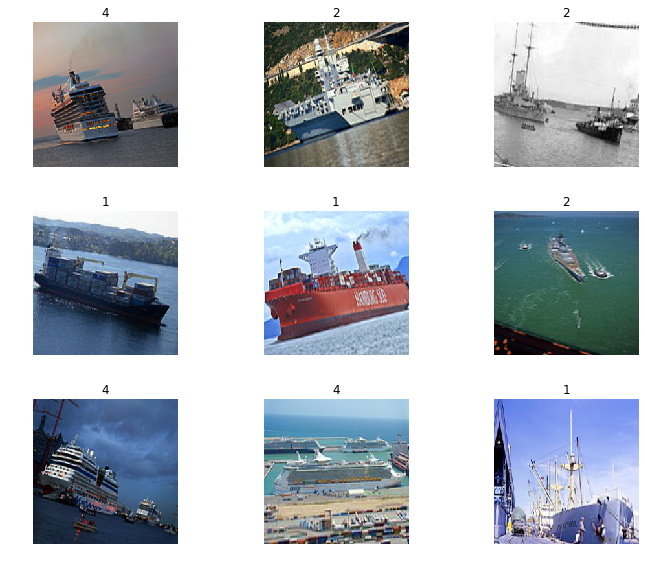

In [14]:
data.show_batch(rows=3, figsize=(10,8))

### Efficientnet-B3

In [15]:
model_name = 'efficientnet-b3'

In [16]:
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model

In [17]:
learn = Learner(data, get_model(), 
                metrics=[FBeta(), accuracy],
                callback_fns=[partial(SaveModelCallback)],
                wd=0.1,
                path = '.').mixup()

Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.torch/models/efficientnet-b3-c8376fa2.pth
49380963it [00:00, 75532626.57it/s]


Loaded pretrained weights for efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


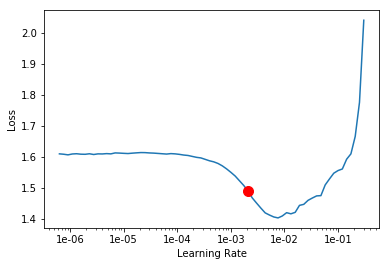

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0020892961308540407

In [20]:
learn.fit_one_cycle(20, min_grad_lr)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.007530,0.403104,0.890594,0.883200,00:55
1,0.690496,0.278599,0.928786,0.921600,00:54
2,0.629961,0.295996,0.922770,0.916000,00:54
3,0.633104,0.329455,0.913424,0.903200,00:54
4,0.622566,0.401206,0.877806,0.875200,00:54
5,0.635267,0.324087,0.905086,0.880800,00:54
6,0.630763,0.611819,0.824704,0.776800,00:54
7,0.596886,0.270182,0.921921,0.908000,00:54
8,0.578664,0.292437,0.916177,0.897600,00:54
9,0.569335,0.226322,0.940609,0.932800,00:54


Better model found at epoch 0 with val_loss value: 0.40310394763946533.
Better model found at epoch 1 with val_loss value: 0.2785985767841339.
Better model found at epoch 7 with val_loss value: 0.2701816260814667.
Better model found at epoch 9 with val_loss value: 0.22632206976413727.
Better model found at epoch 12 with val_loss value: 0.21712282299995422.
Better model found at epoch 13 with val_loss value: 0.17643295228481293.
Better model found at epoch 14 with val_loss value: 0.14209194481372833.
Better model found at epoch 15 with val_loss value: 0.13997796177864075.
Better model found at epoch 16 with val_loss value: 0.13984368741512299.
Better model found at epoch 17 with val_loss value: 0.11865263432264328.
Better model found at epoch 18 with val_loss value: 0.11491074413061142.
Better model found at epoch 19 with val_loss value: 0.11348623037338257.


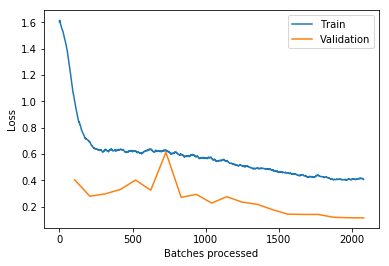

In [21]:
learn.recorder.plot_losses()

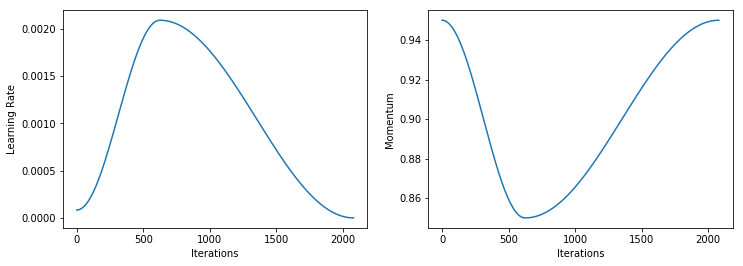

In [22]:
learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


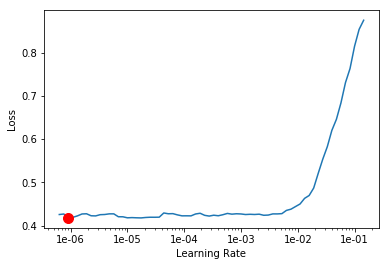

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [24]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

9.120108393559096e-07

In [25]:
learn.fit_one_cycle(20, slice(min_grad_lr))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.400021,0.112891,0.969498,0.964000,00:53
1,0.409808,0.112798,0.971036,0.965600,00:54
2,0.404490,0.112497,0.969629,0.964000,00:54
3,0.400234,0.112733,0.970356,0.964800,00:54
4,0.399239,0.112513,0.970960,0.965600,00:53
5,0.400587,0.112649,0.971158,0.965600,00:54
6,0.399070,0.112856,0.971961,0.966400,00:54
7,0.404072,0.112224,0.970356,0.964800,00:53
8,0.400540,0.112207,0.970767,0.965600,00:54
9,0.403846,0.112244,0.970960,0.965600,00:53


Better model found at epoch 0 with val_loss value: 0.11289079487323761.
Better model found at epoch 1 with val_loss value: 0.11279767751693726.
Better model found at epoch 2 with val_loss value: 0.1124974861741066.
Better model found at epoch 7 with val_loss value: 0.11222385615110397.
Better model found at epoch 8 with val_loss value: 0.11220690608024597.
Better model found at epoch 10 with val_loss value: 0.11207220703363419.
Better model found at epoch 11 with val_loss value: 0.11194505542516708.
Better model found at epoch 12 with val_loss value: 0.11167456954717636.
Better model found at epoch 16 with val_loss value: 0.11165063828229904.
Better model found at epoch 17 with val_loss value: 0.11143950372934341.


In [26]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 0.11143948882818222


In [27]:
learn.save('efficientnet-unfrozen', return_path=True)

PosixPath('models/efficientnet-unfrozen.pth')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [29]:
# interp.plot_top_losses(15, figsize=(15,11))

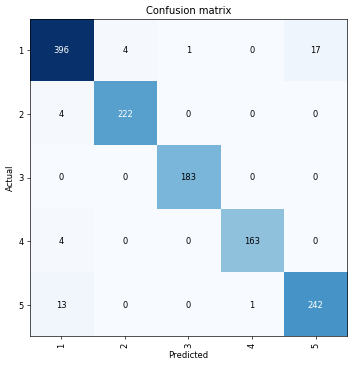

In [30]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[(1, 5, 17), (5, 1, 13), (1, 2, 4), (2, 1, 4), (4, 1, 4)]

In [32]:
probability, classification = learn.TTA(ds_type=DatasetType.Test)

In [33]:
probability.argmax(dim=1)[:10]

tensor([3, 3, 3, 1, 3, 3, 3, 1, 1, 3])

In [34]:
(probability.argmax(dim=1) + 1).unique()

tensor([3, 5, 1, 2, 4])

In [35]:
sample.category = probability.argmax(dim=1) + 1

In [36]:
sample.category.value_counts()

1    932
2    505
5    498
3    391
4    354
Name: category, dtype: int64

In [37]:
sample.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [38]:
sample.to_csv('submission_efficientnetb3_kaggle.csv', index=False)

In [39]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(sample)